In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

In [2]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score,precision_recall_curve,roc_curve
from sklearn import svm

In [3]:
_author='Deepak Mehta'

In [4]:
data=pd.read_csv('creditcard.csv')

In [5]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


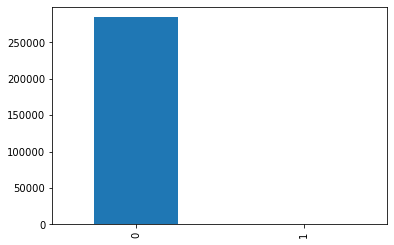

In [6]:
data.Class.value_counts().plot(kind='bar')

In [7]:
data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

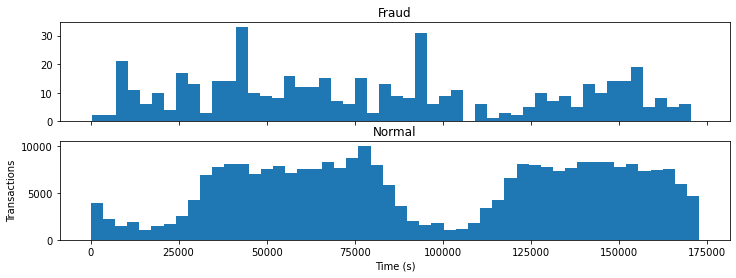

In [8]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))
ax1.hist(data.Time[data.Class == 1], bins = 50)
ax1.set_title('Fraud')
ax2.hist(data.Time[data.Class == 0], bins = 50)
ax2.set_title('Normal')
plt.xlabel('Time (s)')
plt.ylabel('Transactions')
plt.show()

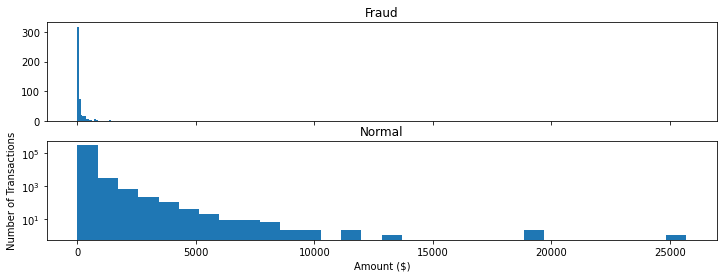

In [9]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))
ax1.hist(data.Amount[data.Class == 1], bins = 30)
ax1.set_title('Fraud')
ax2.hist(data.Amount[data.Class == 0], bins = 30)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

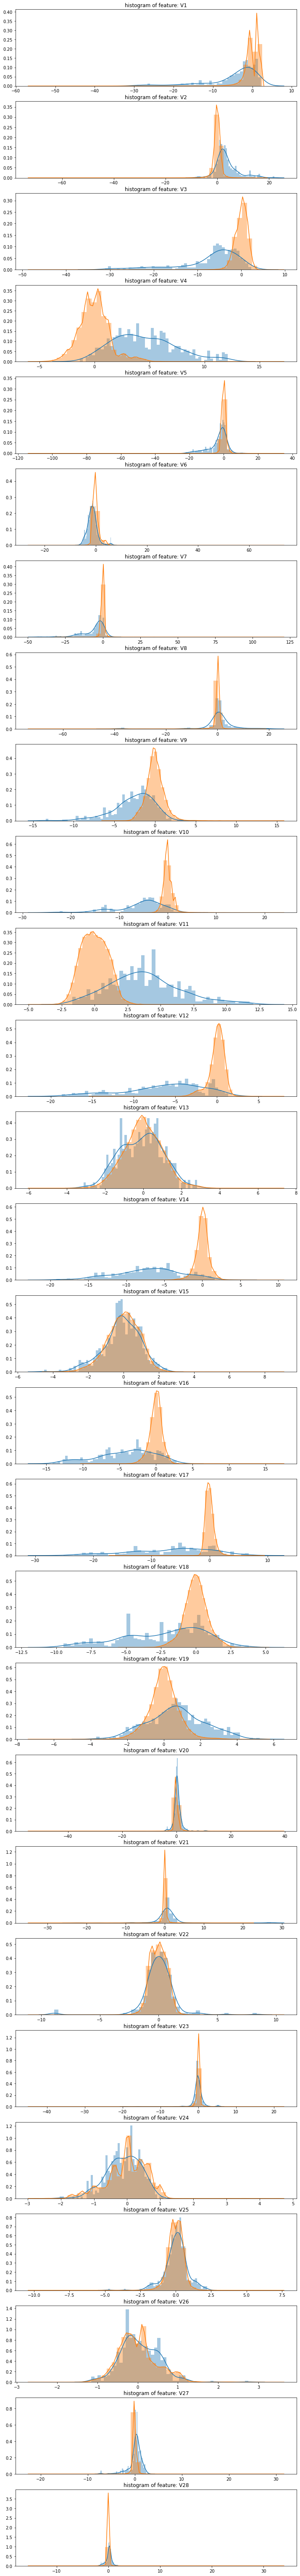

<Figure size 432x288 with 0 Axes>

In [10]:
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i in range(1, 29):
    ax = plt.subplot(gs[i-1])
    sns.distplot(data['V'+str(i)][data.Class == 1], bins=50)
    sns.distplot(data['V'+str(i)][data.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + 'V'+str(i))
plt.show()
plt.tight_layout()

In [11]:
# Based on observation of data overlap above, try out a second dataset with redunancies removed
clean_data = data.drop(['V28','V27','V23','V8'], axis =1)
# Later - can re run everything after running the following line
#data = clean_data

In [12]:
from sklearn.utils import shuffle

In [13]:
#Create dataframes of only Fraud and Normal transactions. Also Shuffle them.
fraud = shuffle(data[data.Class == 1])
normal = shuffle(data[data.Class == 0])
# Produce a training set of 80% of fraudulent and 80% normal transactions
X_train = fraud.sample(frac=0.8)
X_train = pd.concat([X_train, normal.sample(frac = 0.8)], axis = 0)
# Split remainder into testing and validation
remainder = data.loc[~data.index.isin(X_train.index)]
X_test = remainder.sample(frac=0.7)
X_validation = remainder.loc[~remainder.index.isin(X_test.index)]

In [14]:
from imblearn.over_sampling import ADASYN
import logging

In [15]:
ada = ADASYN(n_jobs=3)
#ada.logger.error('test')
#ada.logger.setLevel(logging.INFO)

In [16]:
print('starting...')

data_resampled, data_labels_resampled = ada.fit_sample(
                                            np.array(X_train.iloc[:, X_train.columns != 'Class']), 
                                            np.array(X_train.Class))

starting...


In [17]:
data_resampled.shape,data_labels_resampled.shape

((454922, 30), (454922,))

In [18]:
X_train_resampled=data_resampled

In [19]:
X_train_labels_resampled=data_labels_resampled

In [20]:

from collections import Counter

In [21]:
print(Counter(X_train_labels_resampled))

Counter({1: 227470, 0: 227452})


In [22]:
X_train_resampled = pd.DataFrame(X_train_resampled)
X_train_labels_resampled = pd.DataFrame(X_train_labels_resampled)
X_train_resampled = pd.concat([X_train_resampled, X_train_labels_resampled], axis=1)
X_train_resampled.columns = X_train.columns
X_train_resampled.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,68357.0,1.232604,-0.548931,1.087873,0.894082,-1.433055,-0.356797,-0.717492,0.003167,-0.100397,...,-0.448671,-0.517568,0.012833,0.699217,0.527258,-0.322607,0.080805,0.035427,19.59,1
1,41203.0,-8.426814,6.241659,-9.946470,8.199614,-8.213093,-2.522046,-11.643028,5.339500,-7.051016,...,2.427460,0.692667,0.020305,0.499809,0.467594,0.483162,1.195671,0.198294,88.23,1
2,68207.0,-13.192671,12.785971,-9.906650,3.320337,-4.801176,5.760059,-18.750889,-37.353443,-0.391540,...,27.202839,-8.887017,5.303607,-0.639435,0.263203,-0.108877,1.269566,0.939407,1.00,1
3,92092.0,-1.108478,3.448953,-6.216972,3.021052,-0.529901,-2.551375,-2.001743,1.092432,-0.836098,...,0.825951,1.144170,0.208559,-0.295497,-0.690232,-0.364749,0.229327,0.208830,18.00,1
4,41227.0,-9.001351,6.613284,-12.423635,7.519929,-10.266255,-2.113208,-9.984287,5.541941,-7.383705,...,1.775891,-1.224758,0.082594,0.452089,0.463827,-0.296928,0.526506,-0.450890,459.07,1


In [23]:
# Shuffle the datasets once more to ensure random feeding into the classification algorithms
X_train = shuffle(X_train)
X_test = shuffle(X_test)
X_validation = shuffle(X_validation)
X_train_ = shuffle(X_train_resampled)
X_test_ = shuffle(X_test)
X_validation_ = shuffle(X_validation)
data_resampled = pd.concat([X_train_, X_test_, X_validation_])

In [24]:
data_resampled.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
353710,35627.696084,-2.022873,1.776473,-0.593790,1.547473,0.357504,-0.732593,-1.704131,-2.409342,-0.681426,...,2.633561,-0.878555,-0.143674,-0.072767,-0.285032,0.503229,0.728686,0.212837,1.800812,1
97411,65946.000000,-0.545420,0.599299,1.454579,1.289044,-0.383114,-0.196959,1.006932,0.033723,-0.648312,...,0.050365,-0.123621,0.352894,0.326967,-0.475184,-0.466529,0.124845,0.161239,139.000000,0
445716,167418.988148,1.186869,-0.523919,-1.923738,-0.308213,-0.658622,-0.777827,-1.278180,0.280888,-0.400212,...,0.339543,0.640502,0.038023,0.457658,-0.219096,-0.007540,0.170512,-0.056887,59.075570,1
126293,57315.000000,-1.549037,-0.761846,0.956097,0.905205,0.556592,1.727207,1.016359,0.604561,-0.926478,...,0.528076,0.852497,0.754615,-1.086798,-0.134620,-0.166875,0.051668,0.132837,333.580000,0
388835,41251.076341,-11.206503,6.321367,-14.087676,7.380952,-10.150431,-3.707200,-13.608785,7.242591,-6.507254,...,2.304206,-0.497266,-0.238755,0.482875,-0.058857,0.387966,-0.100275,-0.479838,47.338440,1


In [25]:
# Normalize the data to an average of 0 and std of 1, but do not touch the Class column
for feature in X_train.columns.values[:-1]:
    mean, std = data[feature].mean(), data[feature].std()
    X_train.loc[:, feature] = (X_train[feature] - mean) / std
    X_test.loc[:, feature] = (X_test[feature] - mean) / std
    X_validation.loc[:, feature] = (X_validation[feature] - mean) / std
for feature in X_train_.columns.values[:-1]:
    mean, std = data_resampled[feature].mean(), data_resampled[feature].std()
    X_train_.loc[:, feature] = (X_train_[feature] - mean) / std
    X_test_.loc[:, feature] = (X_test_[feature] - mean) / std
    X_validation_.loc[:, feature] = (X_validation_[feature] - mean) / std

In [26]:
# Create labels
y_train = X_train.Class
y_test = X_test.Class
y_validation = X_validation.Class
y_train_ = X_train_.Class
y_test_ = X_test_.Class
y_validation_ = X_validation_.Class
# Remove labels from X's
X_train = X_train.drop(['Class'], axis=1)
X_train_ = X_train_.drop(['Class'], axis=1)
X_test = X_test.drop(['Class'], axis=1)
X_test_ = X_test_.drop(['Class'], axis=1)
X_validation = X_validation.drop(['Class'], axis=1)
X_validation_ = X_validation_.drop(['Class'], axis=1)

In [27]:
dataset = {'X_train' : X_train,
           'X_train_': X_train_,
           'X_test': X_test,
           'X_test_': X_test,
           'X_validation': X_validation,
           'X_validation_': X_validation_,
           'y_train': y_train,
           'y_train_': y_train_,
           'y_test': y_test,
           'y_test_': y_test_,
           'y_validation': y_validation,
           'y_validation_': y_validation_}

In [28]:
def plot_confusion_matrix(y_test, pred):
    
    y_test_legit = y_test.value_counts()[0]
    y_test_fraud = y_test.value_counts()[1]
    
    cfn_matrix = confusion_matrix(y_test, pred)
    cfn_norm_matrix = np.array([[1.0 / y_test_legit,1.0/y_test_legit],[1.0/y_test_fraud,1.0/y_test_fraud]])
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix

    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(1,2,1)
    sns.heatmap(cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')

    ax = fig.add_subplot(1,2,2)
    sns.heatmap(norm_cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)

    plt.title('Normalized Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()
    
    print('---Classification Report---')
    print(classification_report(y_test,pred))


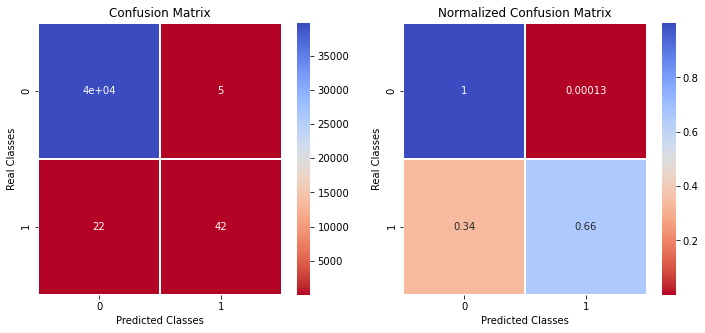

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39809
           1       0.89      0.66      0.76        64

    accuracy                           1.00     39873
   macro avg       0.95      0.83      0.88     39873
weighted avg       1.00      1.00      1.00     39873



In [29]:

# Linear SVM on unsampled training data
lsvm = svm.LinearSVC(C=1.0, dual=False)
lsvm.fit(dataset['X_train'], dataset['y_train'])
y_pred = lsvm.predict(dataset['X_test'])
plot_confusion_matrix(dataset['y_test'], y_pred)

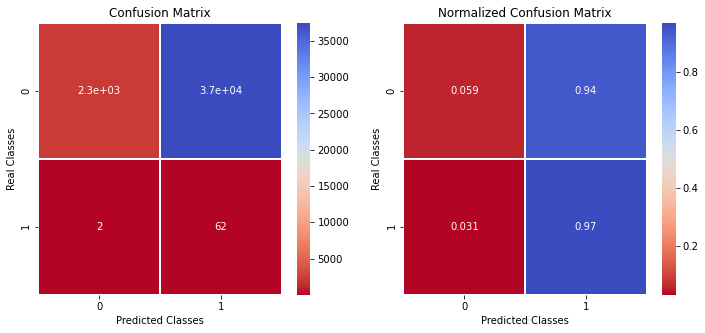

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      0.06      0.11     39809
           1       0.00      0.97      0.00        64

    accuracy                           0.06     39873
   macro avg       0.50      0.51      0.06     39873
weighted avg       1.00      0.06      0.11     39873



In [30]:
# Linear SVM on ADASYN training data #svm_adasyn_unweighted_c0_01
lsvm = svm.LinearSVC(C=1, dual=False)
lsvm.fit(dataset['X_train_'], dataset['y_train_'])
y_pred = lsvm.predict(dataset['X_test_'])
plot_confusion_matrix(dataset['y_test_'], y_pred)

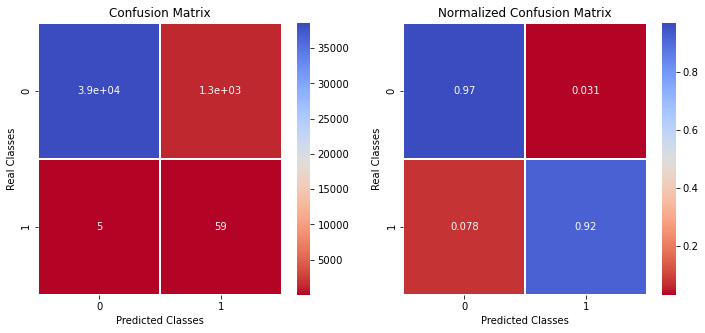

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     39809
           1       0.05      0.92      0.09        64

    accuracy                           0.97     39873
   macro avg       0.52      0.95      0.53     39873
weighted avg       1.00      0.97      0.98     39873



In [31]:
# Linear SVM on WEIGHTED unsampled training data
lsvm = svm.LinearSVC(C=1.0, dual=False, class_weight={1:1000,0:1})
lsvm.fit(dataset['X_train'], dataset['y_train'])
y_pred = lsvm.predict(dataset['X_test'])
plot_confusion_matrix(dataset['y_test'], y_pred)

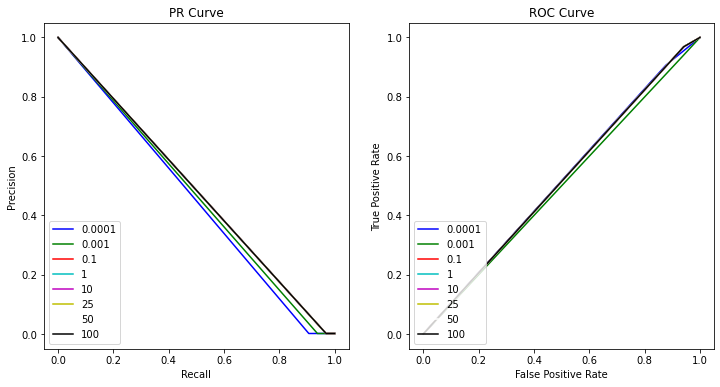

In [32]:
# Not ready to give up on ADASYN, try finding the best C value
# svm_prec_recal_adasyn_different_c
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for c,k in zip([0.0001, 0.001, 0.1, 1, 10, 25, 50, 100],'bgrcmywk'):
    lsvm_ = svm.LinearSVC(C=c, dual=False, class_weight={1:1,0:1})
    lsvm_.fit(dataset['X_train_'], dataset['y_train_'])
    y_pred = lsvm_.predict(dataset['X_test_'])

    p,r,_ = precision_recall_curve(dataset['y_test_'], y_pred)
    tpr,fpr,_ = roc_curve(dataset['y_test_'], y_pred)
    
    ax1.plot(r,p,c=k,label=c)
    ax2.plot(tpr,fpr,c=k,label=c)

ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')
plt.show()
# Conclusion: c > 0.1 is best


0.0001
0.001
0.1
1
10
25
50
100


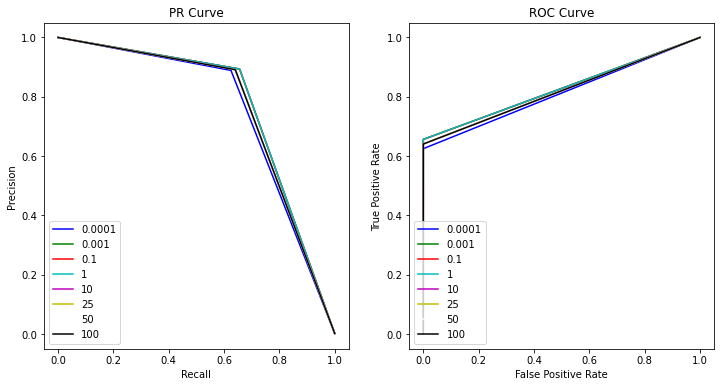

In [33]:
# Same as above but with unsampled data
# svm_prec_recal_unsampled_unweighted_different_c
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for c,k in zip([0.0001, 0.001, 0.1, 1, 10, 25, 50, 100],'bgrcmywk'):
    print(c)
    lsvm_ = svm.LinearSVC(C=c, dual=False, class_weight={1:1,0:1})
    lsvm_.fit(dataset['X_train'], dataset['y_train'])
    y_pred = lsvm_.predict(dataset['X_test'])

    p,r,_ = precision_recall_curve(dataset['y_test'], y_pred)
    tpr,fpr,_ = roc_curve(dataset['y_test'], y_pred)
    
    ax1.plot(r,p,c=k,label=c)
    ax2.plot(tpr,fpr,c=k,label=c)

ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')
plt.show()
# Conclusion: c > 0.1 is best

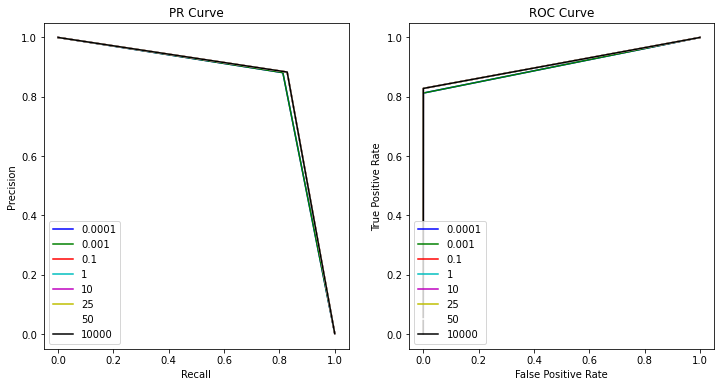

In [34]:
# EXPLORE C VALUE with the WEIGHTED unsampled training data
# svm_prec_recal_weighted_unsampled_different_c
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for c,k in zip([0.0001, 0.001, 0.1, 1, 10, 25, 50, 10000],'bgrcmywk'):
    lsvm_ = svm.LinearSVC(C=c, dual=False, class_weight={1:10,0:1})
    lsvm_.fit(dataset['X_train'], dataset['y_train'])
    y_pred = lsvm_.predict(dataset['X_test'])

    p,r,_ = precision_recall_curve(dataset['y_test'], y_pred)
    tpr,fpr,_ = roc_curve(dataset['y_test'], y_pred)
    
    ax1.plot(r,p,c=k,label=c)
    ax2.plot(tpr,fpr,c=k,label=c)
    
ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')
plt.show()
# CONCLUSION: c > 0.001 is best

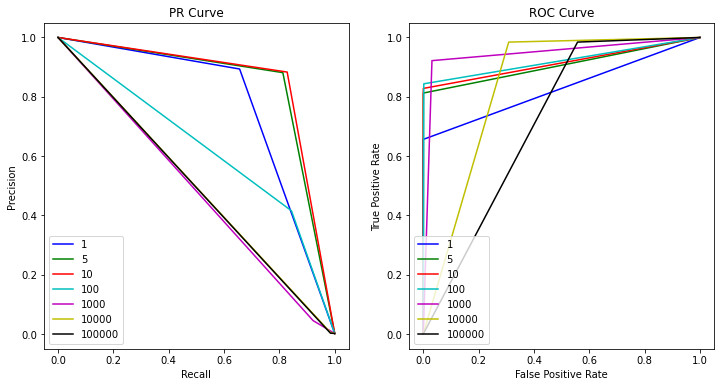

In [35]:
# EXPLORE "class_weight" with c=0.01 since according to above, does not matter. On unsampled data
# Note w=1 is the same as unweighted unsampled training data
#svm_prec_recal_unsampled_different_weights_c_1
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for w,k in zip([1, 5, 10, 100, 1000, 10000, 100000],'bgrcmyk'):
    lsvm_ = svm.LinearSVC(C=1, dual=False, class_weight={1:w,0:1})
    lsvm_.fit(dataset['X_train'], dataset['y_train'])
    y_pred = lsvm_.predict(dataset['X_test'])

    p,r,_ = precision_recall_curve(dataset['y_test'], y_pred, pos_label=1)
    tpr,fpr,_ = roc_curve(dataset['y_test'], y_pred)
    
    ax1.plot(r,p,c=k,label=w)
    ax2.plot(tpr,fpr,c=k,label=w)
    
ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')
plt.show()
# Conclusion: weight of 5 for the minority class works best.
# Note: setting c=1 or c=100 produces the same plots.

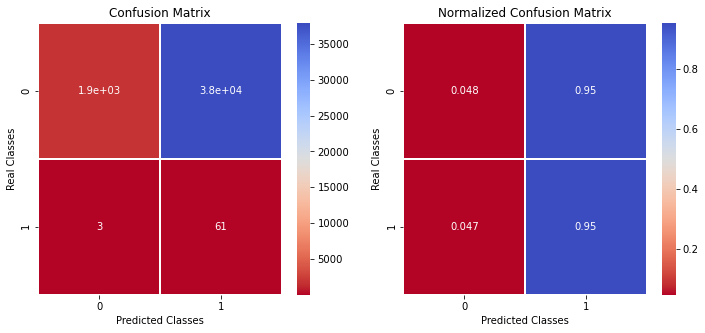

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      0.05      0.09     39809
           1       0.00      0.95      0.00        64

    accuracy                           0.05     39873
   macro avg       0.50      0.50      0.05     39873
weighted avg       1.00      0.05      0.09     39873



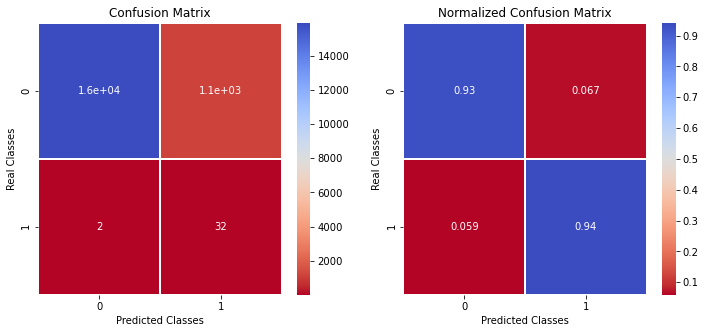

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      0.93      0.97     17054
           1       0.03      0.94      0.05        34

    accuracy                           0.93     17088
   macro avg       0.51      0.94      0.51     17088
weighted avg       1.00      0.93      0.96     17088



In [36]:
# Linear SVM on WEIGHTED ADASYN training data with minority class weight of 10
# svm_adasyn_c_1_weight_10
lsvm = svm.LinearSVC(C=1, dual=False, class_weight={1:10,0:1})
lsvm.fit(dataset['X_train_'], dataset['y_train_'])
y_pred = lsvm.predict(dataset['X_test_'])
y_pred_validation = lsvm.predict(dataset['X_validation_'])
plot_confusion_matrix(dataset['y_test_'], y_pred)
plot_confusion_matrix(dataset['y_validation_'], y_pred_validation)
# Conclusion: no bueno.

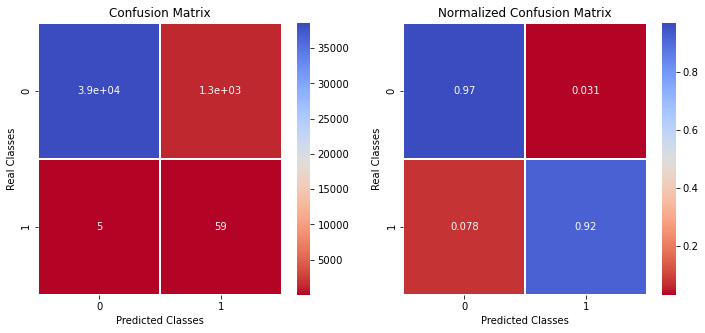

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     39809
           1       0.05      0.92      0.09        64

    accuracy                           0.97     39873
   macro avg       0.52      0.95      0.53     39873
weighted avg       1.00      0.97      0.98     39873



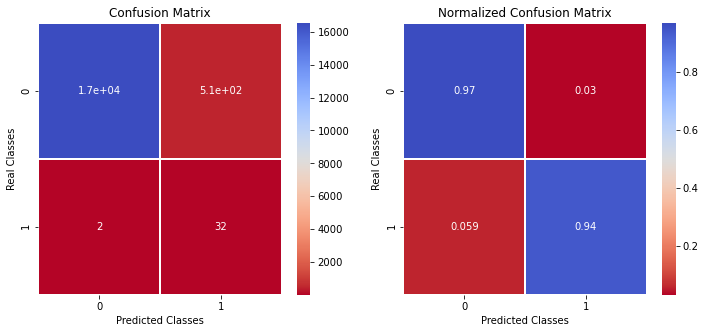

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     17054
           1       0.06      0.94      0.11        34

    accuracy                           0.97     17088
   macro avg       0.53      0.96      0.55     17088
weighted avg       1.00      0.97      0.98     17088



In [37]:
# Linear SVM on WEIGHTED unsampled training data with minority class weight of 1000
lsvm = svm.LinearSVC(C=1, dual=False, class_weight={1:1000,0:1})
lsvm.fit(dataset['X_train'], dataset['y_train'])
y_pred = lsvm.predict(dataset['X_test'])
y_pred_validation = lsvm.predict(dataset['X_validation'])
plot_confusion_matrix(dataset['y_test'], y_pred)
plot_confusion_matrix(dataset['y_validation'], y_pred_validation)

fitting
predicting test
predicting validation


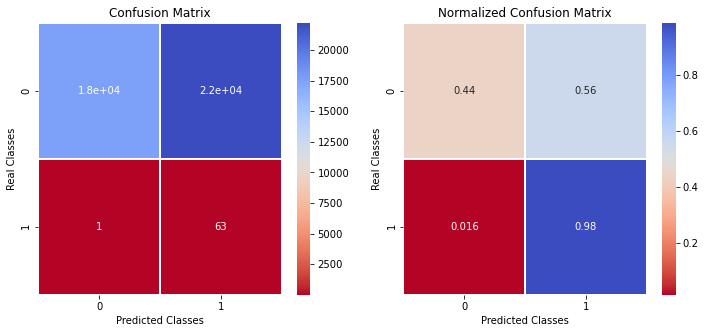

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      0.44      0.61     39809
           1       0.00      0.98      0.01        64

    accuracy                           0.44     39873
   macro avg       0.50      0.71      0.31     39873
weighted avg       1.00      0.44      0.61     39873



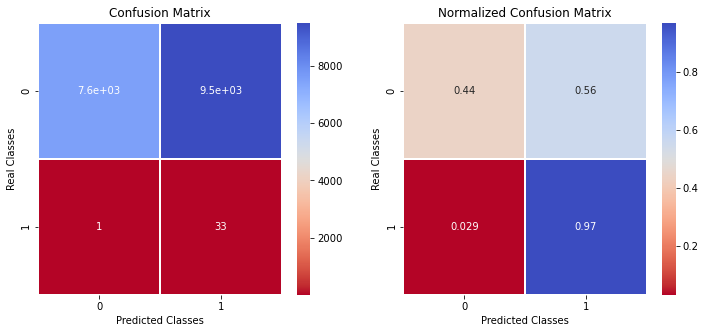

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      0.44      0.61     17054
           1       0.00      0.97      0.01        34

    accuracy                           0.44     17088
   macro avg       0.50      0.71      0.31     17088
weighted avg       1.00      0.44      0.61     17088



In [38]:
# Linear SVM on WEIGHTED unsampled training data with minority class weight of 100000
lsvm = svm.LinearSVC(C=1, dual=False, class_weight={1:100000,0:1})
print('fitting')
lsvm.fit(dataset['X_train'], dataset['y_train'])
print('predicting test')
y_pred = lsvm.predict(dataset['X_test'])
print('predicting validation')
y_pred_validation = lsvm.predict(dataset['X_validation'])
plot_confusion_matrix(dataset['y_test'], y_pred)
plot_confusion_matrix(dataset['y_validation'], y_pred_validation)
# Conclusion: clearly too high of a minority class weight - compromising TP rate.

In [39]:
from sklearn.ensemble import RandomForestClassifier

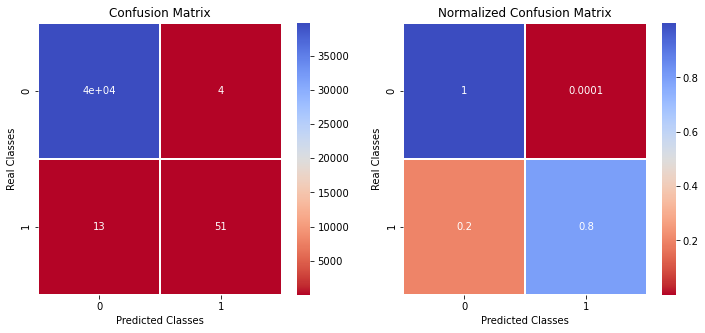

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39809
           1       0.93      0.80      0.86        64

    accuracy                           1.00     39873
   macro avg       0.96      0.90      0.93     39873
weighted avg       1.00      1.00      1.00     39873



In [40]:
# Random Forest on unsampled training data
# rf_n_est_100_unsampled_unweighted
rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=4)
rf.fit(dataset['X_train'], dataset['y_train'])
y_pred = rf.predict(dataset['X_test'])
plot_confusion_matrix(dataset['y_test'], y_pred)

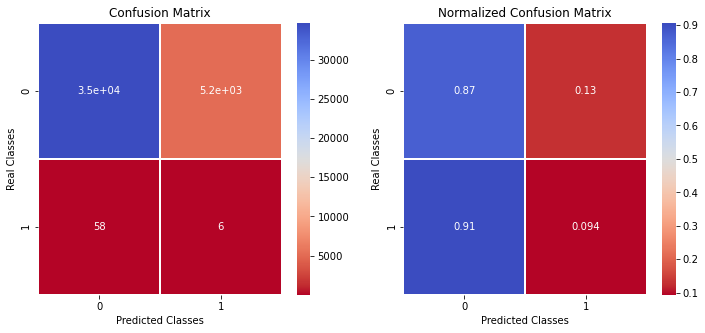

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     39809
           1       0.00      0.09      0.00        64

    accuracy                           0.87     39873
   macro avg       0.50      0.48      0.47     39873
weighted avg       1.00      0.87      0.93     39873



In [41]:

# Random Forest on ADASYN training data
rf_adasyn = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=4)
rf_adasyn.fit(dataset['X_train_'], dataset['y_train_'])
y_pred = rf_adasyn.predict(dataset['X_test_'])
plot_confusion_matrix(dataset['y_test_'], y_pred)

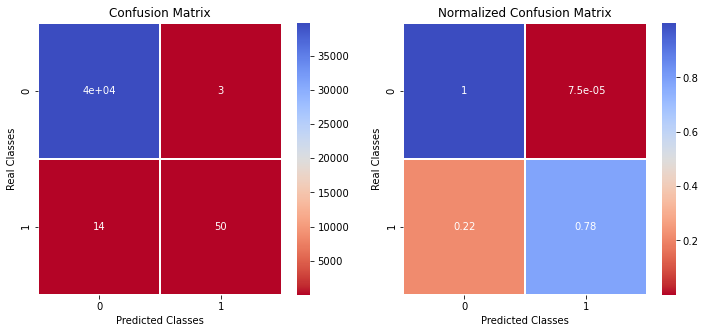

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39809
           1       0.94      0.78      0.85        64

    accuracy                           1.00     39873
   macro avg       0.97      0.89      0.93     39873
weighted avg       1.00      1.00      1.00     39873



In [42]:

# Random Forest on WEIGHTED unsampled training data
rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=4, class_weight={1:10,0:1})
rf.fit(dataset['X_train'], dataset['y_train'])
y_pred = rf.predict(dataset['X_test'])
plot_confusion_matrix(dataset['y_test'], y_pred)

10
50
100
250
500


KeyboardInterrupt: 

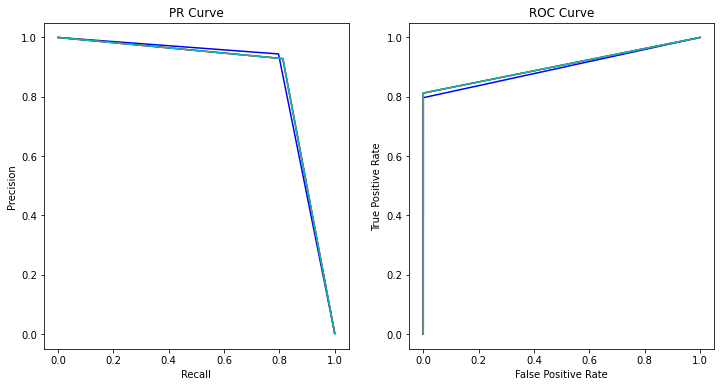

In [43]:
# Unsampled training data # rf_prec_recall_n_est_unsampled_unweighted
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for n_est,k in zip([10, 50, 100, 250, 500, 1000],'bgrcmy'):
    print(n_est)
    rf = RandomForestClassifier(n_estimators=n_est, bootstrap=False, max_features=0.33, n_jobs=4)
    rf.fit(dataset['X_train'], dataset['y_train'])
    y_pred = rf.predict(dataset['X_test'])

    p,r,_ = precision_recall_curve(dataset['y_test'], y_pred)
    tpr,fpr,_ = roc_curve(dataset['y_test'], y_pred)
    
    ax1.plot(r,p,c=k,label=n_est)
    ax2.plot(tpr,fpr,c=k,label=n_est)

ax1.legend(loc='lower left')
ax2.legend(loc='lower left')
plt.show()
# Conclusion: n_estimators=100 is best

In [ ]:
# Not ready to give up on ADASYN, try finding the best C value #rf_prec_recall_n_est_adasyn_unweighted
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for n_est,k in zip([1, 10, 50, 100, 500, 1000],'bgrcmy'):
    rf_adasyn_ = RandomForestClassifier(n_estimators=n_est, oob_score=True, n_jobs=4)
    rf_adasyn_.fit(dataset['X_train_'], dataset['y_train_'])
    y_pred = rf_adasyn_.predict(dataset['X_test_'])

    p,r,_ = precision_recall_curve(dataset['y_test_'], y_pred)
    tpr,fpr,_ = roc_curve(dataset['y_test_'], y_pred)
    
    ax1.plot(r,p,c=k,label=n_est)
    ax2.plot(tpr,fpr,c=k,label=n_est)

ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')
plt.show()
# Conclusion:

In [ ]:
# Unsampled training data, WEIGHTED - explore different weights
# rf_prec_recall_n_est_unsampled_n_est_100_different_weights
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for w,k in zip([1, 10, 50, 100, 250, 500, 1000],'bgrcmyk'):
    print(w)
    rf = RandomForestClassifier(n_estimators=100, bootstrap=False, 
                                max_features=0.33, n_jobs=4, 
                                class_weight={1:w,0:1})
    rf.fit(dataset['X_train'], dataset['y_train'])
    y_pred = rf.predict(dataset['X_test'])

    p,r,_ = precision_recall_curve(dataset['y_test'], y_pred)
    tpr,fpr,_ = roc_curve(dataset['y_test'], y_pred)
    
    ax1.plot(r,p,c=k,label=w)
    ax2.plot(tpr,fpr,c=k,label=w)

ax1.legend(loc='lower left')
ax2.legend(loc='lower left')
plt.show()
# Conclusion: 50 works best